# Visión Artificial

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [ ]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [64]:
#Carga de datos
labels = pd.read_csv('/dataset/labels.csv')

datagen_vis = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen_vis.flow_from_dataframe(
        dataframe=labels,
        directory='/dataset/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 3056 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4535 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


## EDA

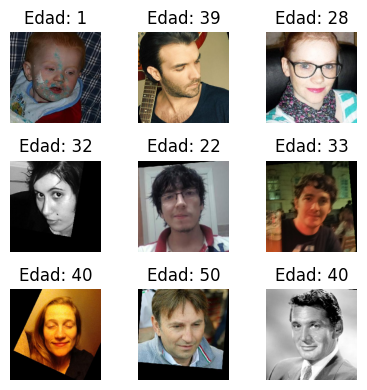

In [65]:
images, ages = next(datagen_flow)

plt.figure(figsize=(4, 4))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Edad: {int(ages[i])}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [66]:
labels['real_age'].describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


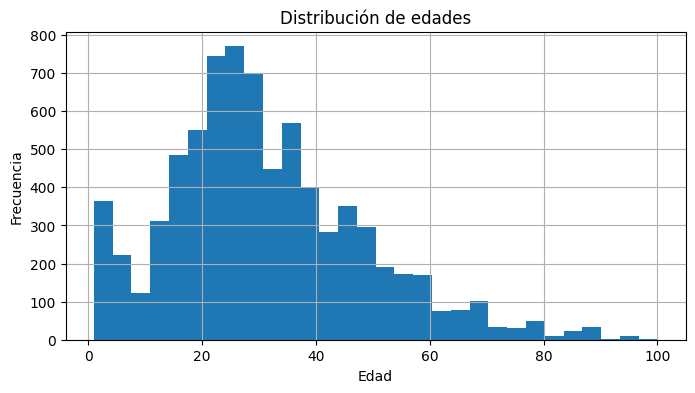

In [67]:
plt.figure(figsize=(8, 4))
labels['real_age'].hist(bins=30)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de edades')
plt.grid(True)
plt.show()

### Conclusiones

Tenemos datos con edades desde 1 a 100 años, aunque la mayoría de estos se encuentran al rededor de nuestra mediana, de 29 años, y después de los 60 disminuye la cantidad de información disponible.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [69]:
def load_data(path, target_size=(224,224), batch_size=32, validation_split=0.2):

    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')
    seed = 31416
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split,
        rotation_range=20,         # Rotate images by up to 20 degrees
        width_shift_range=0.2,     # Shift images horizontally
        height_shift_range=0.2,    # Shift images vertically
        zoom_range=0.2,            # Zoom in/out on images
        horizontal_flip=True       # Flip images horizontally
    )

    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col= 'file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size= 32,
        class_mode='raw',
        subset='training',
        seed=seed
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col= 'file_name',
        y_col='real_age',
        target_size=  target_size,
        batch_size= batch_size,
        class_mode='raw',
        subset='validation',
        seed=seed
    )

    return train_gen, val_gen

In [70]:
train_data, val_data = load_data('/dataset/')

Found 2445 validated image filenames.
Found 611 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4535 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [80]:
def create_model(input_shape, trainable=True):

    """
    Define el modelo
    """

    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    backbone.trainable = trainable

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.00005)  # Reduced learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [81]:
def train_model(model, train_data, test_data, epochs=3,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """

    model.fit(train_data, validation_data = test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              epochs=epochs, verbose=2)

    return model

### Creación y entrenamiento del modelo

In [82]:
input_shape = (224, 224, 3)
model_resnet = create_model(input_shape)

In [83]:
model_resnet = train_model(model_resnet, train_data, val_data, epochs = 15)

Epoch 1/15
77/77 - 150s - 2s/step - loss: 612.4097 - mae: 19.5972 - val_loss: 1039.0759 - val_mae: 27.6783
Epoch 2/15
77/77 - 51s - 664ms/step - loss: 135.4355 - mae: 8.7967 - val_loss: 1021.4338 - val_mae: 27.3701
Epoch 3/15
77/77 - 52s - 669ms/step - loss: 97.5527 - mae: 7.4659 - val_loss: 981.6152 - val_mae: 26.6709
Epoch 4/15
77/77 - 53s - 687ms/step - loss: 81.3967 - mae: 6.9188 - val_loss: 986.4691 - val_mae: 26.7624
Epoch 5/15
77/77 - 51s - 666ms/step - loss: 72.0761 - mae: 6.4882 - val_loss: 976.5946 - val_mae: 26.6133
Epoch 6/15
77/77 - 51s - 666ms/step - loss: 59.6909 - mae: 5.9378 - val_loss: 812.8751 - val_mae: 23.7567
Epoch 7/15
77/77 - 52s - 681ms/step - loss: 57.4908 - mae: 5.7591 - val_loss: 368.3143 - val_mae: 14.5155
Epoch 8/15
77/77 - 52s - 673ms/step - loss: 50.2727 - mae: 5.3981 - val_loss: 271.1902 - val_mae: 12.1962
Epoch 9/15
77/77 - 51s - 660ms/step - loss: 45.2372 - mae: 5.1932 - val_loss: 215.0768 - val_mae: 10.7842
Epoch 10/15
77/77 - 51s - 661ms/step - loss

### Resultado

Epoch 14/15
77/77 - 51s - 664ms/step - loss: 33.7972 - mae: 4.4329 - val_loss: 76.1371 - val_mae: 6.6165
Epoch 15/15
77/77 - 51s - 657ms/step - loss: 33.2058 - mae: 4.4611 - val_loss: 85.0746 - val_mae: 7.1445

## Conclusiones

Logramos obtener el valor esperado del MAE para el conjunto de validación, con 14 epochs el val_mae fue de 6.16, cuando necesitabamos menos de 8. Para mejorar este valor se hicieron varias pruebas, y lo que funcionó fue añadir una capa Dropout con un dorpout rate de .5, y ajustar el learning rate de adam a .00005, además de utilizar técnicas de aumento para el conjunto de entrenamiento.

Con este modelo ahora podemos hacer predicciones suficientemente acertadas de la edad de una persona basándonos en fotos.


## Comentario general del revisor 

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a>
    
¡Felicitaciones por completar este proyecto de aprendizaje profundo con ResNet50! Elegiste abordar un reto **opcional**, lo que refleja una actitud proactiva y una clara motivación por seguir desarrollándote en el área. Esa dedicación es clave para avanzar en inteligencia artificial y ciencia de datos.

### ResNet50 y decisiones técnicas

Integraste de forma adecuada una arquitectura de alto nivel como **ResNet50**, aplicando técnicas efectivas como *dropout* y una tasa de aprendizaje reducida. Gracias a estas decisiones, lograste un **MAE en validación inferior a 8**, cumpliendo con los criterios del proyecto y mostrando un modelo bien ajustado.

Además, estructuraste el código de manera modular y funcional, preparado para ejecutarse en entornos con GPU. Este enfoque es esencial en el desarrollo de soluciones escalables y eficientes en la nube.

### Valor profesional

Este proyecto demuestra competencias relevantes en visión por computadora, ajuste de modelos y gestión de datos reales. Haberlo completado, a pesar de ser opcional, resalta tu compromiso y tu interés genuino por adquirir experiencia práctica en deep learning.

Sin duda, estás construyendo una base técnica sólida. Te animo a seguir explorando nuevas arquitecturas y desafíos, siempre con la misma curiosidad y constancia que mostraste aquí. ¡Muy bien logrado!
</div>
